- KEYWORDS: numpy.linalg.solve, numpy.linalg.lstsq


## Followup on showing the normal equation minimizes SSE



We examined this regression problem in class today.



# Out [18]:
# output
[ 4.99902597e-02 -2.97846320e-04  1.34348485e-06 -3.48484848e-09
  3.69696970e-12]

# text/plain

# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

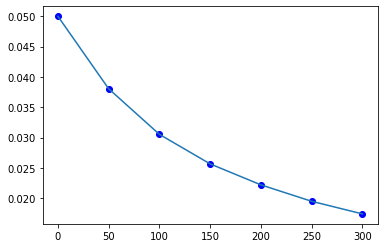

In [1]:
import numpy as np

time = np.array([0.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0])
Ca = np.array([50.0, 38.0, 30.6, 25.6, 22.2, 19.5, 17.4]) * 1e-3

X = np.column_stack([time**0, time, time**2, time**3, time**4])

a = np.linalg.solve(X.T @ X, X.T @ Ca)
print(a)

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(time, Ca, "bo")
plt.plot(time, X @ a)

That looks good. We should be able to show that the derivative of the summed squared errors with respect to each parameter is zero at the minimum. Let's try using numdifftools for this. I showed you this in class, and we saw a little surprise.



In [1]:
import numdifftools as nd


def SSE(pars):
    errs = X @ pars - Ca
    return errs @ errs


J = nd.Jacobian(SSE)
J(a)

# Out [3]:
# text/plain
array([[-3.19189120e-16,  9.38367549e-15,  4.62079277e-10,
        -3.28306822e-04, -9.60000000e+00]])

The first two of these values are very small, but they progressively get larger. That should be concerning, but let's remember numdifftools uses finite differences. It could be that this is not sufficiently accurate for this purpose, especially for a term like $t^4$ in it.

One way to test this is to derive an analytical derivative.

$SSE = \sum (X @ pars - Ca)^2$

so we can work out the following derivative using the chain rule,

$\frac{dSSE}{dpars} = 2 \sum (X @ pars - Ca) @ X$

And evaluating this leads to *much smaller* derivatives.



In [1]:
2 * (X @ a - Ca) @ X

# Out [7]:
# text/plain
array([-3.12250226e-16,  1.17961196e-14, -1.83886240e-12, -1.55776547e-09,
       -1.20649929e-07])

I am not a huge fan of working out those derivatives, so let's double check our work with autograd, which provides exact derivatives using automatic differentiation. We will learn more about autograd soon.



In [1]:
from autograd import jacobian

Ja = jacobian(SSE)
Ja(a)

# Out [8]:
# text/plain
array([-3.12250226e-16,  1.17961196e-14, -1.83886240e-12, -1.55776547e-09,
       -1.20649929e-07])

These both agree, suggesting the analytical derivative is correct. So, why do the errors get larger in these terms? This is caused by catastrophic accumulation of errors that arises from adding and subtracting large and small numbers.



In [1]:
X.min(), X.max()

# Out [10]:
# text/plain
(0.0, 8100000000.0)

### Is the Hessian positive definite?



As before we can see that the Hessian is positive definite, but as before we should be skeptical here if the Hessian in numdifftools is sufficiently accurate, especially since we see 18 orders of magnitude among the eigenvalues.



In [1]:
H = nd.Hessian(SSE)
np.linalg.eigvals(H(a))

# Out [12]:
# text/plain
array([1.67392305e+20, 2.87547709e+13, 5.43139168e+07, 2.02420036e+00,
       9.28150756e+02])

The Jacobian was defined as:

$\frac{dSSE}{dpars} = 2 \sum (X @ pars - Ca) @ X$

The analytical Hessian is defined by:

$\frac{dSSE^2}{d^pars} = 2 X^T X$

We evaluate that to see that here the Hessian happens to be quite accurate. You can see why, it does not depend on the parameters at all, so there are not errors associated with finite differences.



In [1]:
np.linalg.eigvals(2 * X.T @ X)

# Out [17]:
# text/plain
array([1.67392305e+20, 2.87547709e+13, 5.43139168e+07, 2.02418206e+00,
       9.28150368e+02])

Here we confirm this with autograd again.



In [1]:
from autograd import hessian

Ha = hessian(SSE)
np.linalg.eigvals(Ha(a))

# Out [14]:
# text/plain
array([1.67392305e+20, 2.87547709e+13, 5.43139168e+07, 2.02418206e+00,
       9.28150368e+02])

## pycse.regress



Somehow, I neglected to introduce the `pycse.regress` function which is the linear regression analog of `pycse.nlinfit`. It is a thin wrapper around `np.linalg.lstsq` that does the confidence interval computation for you.



In [1]:
from pycse import regress

p, pint, se = regress(X, Ca, 0.05)
print(p)

# Out [20]:
# output
[ 4.99902596e-02 -2.97846320e-04  1.34348484e-06 -3.48484840e-09
  3.69696954e-12]
/Users/jkitchin/vc/projects/gumroad-books/pycse/pycse/PYCSE.py:62: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b, res, rank, s = np.linalg.lstsq(A, y)

Note in these confidence intervals, The last two contain zero, indicating they are very uncertain. This is a little different than what is in the notes. That is because `regress` uses one less degree of freedom than I did in the notes which makes the CI a little larger. The argument for doing that is related to how the parameters are counted and whether you count the intercept as a parameter or not. `regress` may be overcounting the parameters in this case, leading to a larger CI than needed. When you have a lot of data, this error is negligible.



In [1]:
print(pint)

# Out [21]:
# output
[[ 4.90747573e-02  5.09057619e-02]
 [-3.49867290e-04 -2.45825350e-04]
 [ 5.40268319e-07  2.14670135e-06]
 [-7.67338629e-09  7.03689494e-10]
 [-3.23368759e-12  1.06276267e-11]]